Tutorial 7: Data
================

In this example, we'll use the 'imaging' module to simulate _Imaging_ of a strong lens made using a _Tracer_. By
simulate, we mean that it will appear as if we had observed it using a real telescope, with this example making an
image representative of Hubble Space Telescope imaging.

In [1]:
%matplotlib inline

import autolens as al
import autolens.plot as aplt

To simulate an image, we need to model the telescope's optics. We'll do this by convolving the image with a 
Point-Spread Function using a _Kernel_ object, which we can simulate as a Gaussian.

In [18]:
psf = al.Kernel.from_gaussian(shape_2d=(11, 11), sigma=0.1, pixel_scales=0.1)

To simulate _Imaging_ dataset, we use a _Grid_, like usual.

In [19]:
grid = al.Grid.uniform(shape_2d=(100, 100), pixel_scales=0.1, sub_size=2)

Now, lets setup our lens galaxy, source galaxy and _Tracer_.

In [20]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllipticalIsothermal(
        centre=(0.0, 0.0), einstein_radius=1.6, elliptical_comps=(0.17647, 0.0)
    ),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    light=al.lp.EllipticalSersic(
        centre=(0.1, 0.1),
        elliptical_comps=(0.0, 0.111111),
        intensity=1.0,
        effective_radius=1.0,
        sersic_index=2.5,
    ),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

Lets look at the _Tracer_'s image - this is the image we'll be simulating.

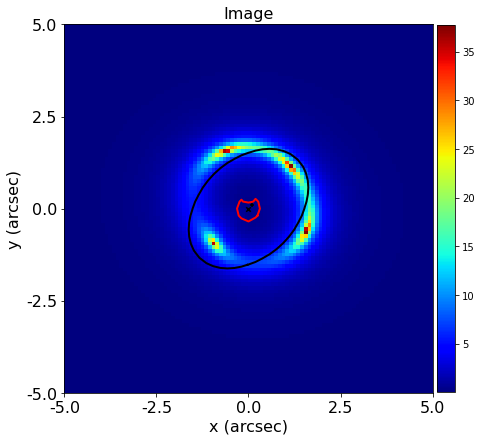

In [21]:
aplt.Tracer.image(tracer=tracer, grid=grid)

To Simulate the Imaging data, we don't use the image plotted above. Instead, we use an image which has been generated
specifically for simulating an image, which pads the array it is computed on based on the shape of the PSF we
 convolve the image with. This ensures edge-effects do not degrade our simulation's PSF convolution.

In [15]:
normal_image = tracer.image_from_grid(grid=grid)
padded_image = tracer.padded_image_from_grid_and_psf_shape(
    grid=grid, psf_shape_2d=psf.shape_2d
)
print(normal_image.shape)
print(padded_image.shape)

(40000,)
(48400,)


Now, to simulate the _Imaging_ data, we pass the _Tracer_ and _Grid_ to the _Imaging_ module's simulate function. This adds
the following effects to the image:

    1) Telescope optics: Using the Point Spread Function above.
    2) The Background Sky: Although the image that is returned is automatically background sky subtracted.
    3) Poisson noise: Due to the background sky, lens galaxy and source galaxy Poisson photon counts.

In [16]:
simulator = al.SimulatorImaging(
    exposure_time_map=al.Array.full(fill_value=300.0, shape_2d=grid.shape_2d),
    psf=psf,
    background_sky_map=al.Array.full(fill_value=0.1, shape_2d=grid.shape_2d),
    add_noise=True,
)

imaging = simulator.from_tracer_and_grid(tracer=tracer, grid=grid)

Lets plot the image - we can see the image has been blurred due to the telescope optics and noise has been added.

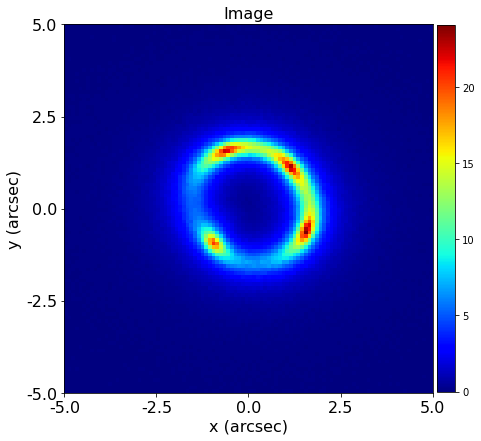

In [8]:
aplt.Imaging.image(imaging=imaging)

Finally, lets output these files to.fits files, we'll begin to analyze them in the next tutorial!

The data path specifies where the data is output, this time in the directory 'chapter_path/data'.

Recall that we use the library pyprojroot to get a relative path to the autolens_workspace, double check this path
is correct on your computer!

In [9]:
from pyprojroot import here

workspace_path = str(here())
dataset_path = f"{workspace_path}/howtolens/dataset/chapter_1"
print("Dataset Path: ", dataset_path)

Dataset Path:  /home/carlos/autolens_workspace/howtolens/dataset/chapter_1


Now output our simulated data to hard-disk.

In [10]:
imaging.output_to_fits(
    image_path=f"{dataset_path}/image.fits",
    noise_map_path=f"{dataset_path}/noise_map.fits",
    psf_path=f"{dataset_path}/psf.fits",
    overwrite=True,
)
